In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [54]:
# Manage paths
%run setup_notebooks.py

In [4]:
from toolbox import wandb_export
from src import setup

In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Introduction

## About

Sweep: train with high number of epochs, enable early stopping with max $N_\text{stop}$ epochs of non-improving validation loss. If training stops at $N_\text{epoch}$, log the metrics at epoch $N_\text{epoch} - N_\text{stop}$ as the run summary.

This has many issues, see the slides. Here we investigate: huge overfitting of validation data and spurious performance.

## Setup

In [6]:
sweep_id = 'm41et5rs'

# Data retrieval

In [7]:
path = setup.get_local_data_path().joinpath('wandb_export_sweep_m41et5rs.csv')
raw = pd.read_csv(path)
raw.columns = map(str.lower, raw.columns)
print(raw.shape)
raw.head()

(240, 47)


,name,agent,state,notes,user,tags,created,runtime,sweep,allow_stop,...,train.recall,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss
0,faithful-sweep-240,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:58:07.000Z,132,m41et5rs,100,...,0.900000,130,0.4375,1,0.608696,0.695688,0.4375,1.0,7,0.695688
1,dainty-sweep-239,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:55:48.000Z,134,m41et5rs,100,...,0.769231,130,0.4375,1,0.608696,0.691538,0.4375,1.0,7,0.691538
2,vibrant-sweep-238,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:53:54.000Z,112,m41et5rs,100,...,0.269231,130,0.5625,1,0.000000,0.690663,0.0000,0.0,7,0.690663
3,bright-sweep-237,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:52:00.000Z,107,m41et5rs,100,...,0.476923,130,0.5625,1,0.000000,0.708929,0.0000,0.0,7,0.708929
4,prime-sweep-236,vprqj54b,finished,-,mazeller,NaN,2022-03-18T06:49:38.000Z,136,m41et5rs,100,...,1.000000,130,0.4375,3,0.608696,0.689223,0.4375,1.0,7,0.689223


In [8]:
# Sanity check
assert raw.sweep.nunique() == 1

In [9]:
# Discard useless columns
df = raw.drop(columns=['name', 'agent', 'state', 'notes', 'user', 'tags', 'created', 'runtime', 'sweep'])
# Keep only columns with different values
mask = df.nunique() > 1
df = df[mask[mask].index]

df

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,cv.fold_id,train.accuracy,train.epoch,train.f1-score,train.loss,train.precision,train.recall,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss
0,6,1,16,0.0001,9,0.411765,1,0.565217,0.698471,0.411972,0.900000,130,0.437500,1,0.608696,0.695688,0.437500,1.000,7,0.695688
1,6,1,16,0.0020,9,0.421569,1,0.530504,0.694247,0.404858,0.769231,130,0.437500,1,0.608696,0.691538,0.437500,1.000,7,0.691538
2,6,1,8,0.0001,9,0.562092,1,0.343137,0.705715,0.472973,0.269231,130,0.562500,1,0.000000,0.690663,0.000000,0.000,7,0.690663
3,6,1,8,0.0020,9,0.480392,1,0.438163,0.707489,0.405229,0.476923,130,0.562500,1,0.000000,0.708929,0.000000,0.000,7,0.708929
4,6,0,16,0.0001,9,0.424837,3,0.596330,0.691561,0.424837,1.000000,130,0.437500,3,0.608696,0.689223,0.437500,1.000,7,0.689223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3,1,8,0.0020,0,0.622517,56,0.592857,0.657469,0.546053,0.648438,128,0.555556,56,0.600000,0.583694,0.500000,0.750,8,0.583694
236,3,0,16,0.0001,0,0.788079,404,0.753846,0.540775,0.742424,0.765625,128,0.666667,404,0.666667,0.554184,0.600000,0.750,8,0.554184
237,3,0,16,0.0020,0,0.655629,79,0.614815,0.622864,0.584507,0.648438,128,0.722222,79,0.736842,0.494799,0.636364,0.875,8,0.494799
238,3,0,8,0.0001,0,0.543046,220,0.566038,0.676244,0.473684,0.703125,128,0.500000,220,0.470588,0.661299,0.444444,0.500,8,0.661299


In [10]:
df.nunique().sort_values()

num_gin              2
num_hidden_dim       2
optimizer.lr         2
val.support          2
train.support        2
num_equiv            3
cv.fold_id          10
val.recall          14
val.accuracy        30
val.precision       34
val.f1-score        52
train.recall        99
train.accuracy     157
train.epoch        160
val.epoch          160
train.precision    217
train.f1-score     222
train.loss         240
val.loss           240
val_loss           240
dtype: int64

In [11]:
# Sanity check
df['cv.fold_id'].value_counts()

9    24
8    24
7    24
6    24
5    24
4    24
3    24
2    24
1    24
0    24
Name: cv.fold_id, dtype: int64

There are 24 models in total that we want to aggregate on the 10 folds.

In [12]:
hyperparams = df.columns.drop(e for e in df.columns if 'val' in e or 'train' in e)
hyperparams = hyperparams.drop('cv.fold_id')
hyperparams

Index(['num_equiv', 'num_gin', 'num_hidden_dim', 'optimizer.lr'], dtype='object')

In [13]:
# Sanity check: are there all folds for each hyperparam combin ?
df.groupby(hyperparams.tolist()).val_loss.count()

num_equiv  num_gin  num_hidden_dim  optimizer.lr
3          0        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
           1        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
4          0        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
           1        8               0.0001          10
                                    0.0020          10
                    16              0.0001          10
                                    0.0020          10
6          0        8               0.0001          10
                

## Aggregate over folds

In [21]:
aggreg = {col: ('mean', 'std') for col in ('val.loss', 'train.loss', 'val.f1-score', 'train.f1-score', 'train.epoch')}
res = df.groupby(hyperparams.tolist()).agg(aggreg)
# Flatten hierarchical columns
cols = ['.'.join(e) for e in res.columns.to_flat_index()]
res.columns = cols
# Build mapping hyperparams -> config name
map_config = res.index

res.reset_index(inplace=True)

res

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,val.loss.mean,val.loss.std,train.loss.mean,train.loss.std,val.f1-score.mean,val.f1-score.std,train.f1-score.mean,train.f1-score.std,train.epoch.mean,train.epoch.std
0,3,0,8,0.0001,0.656036,0.037060,0.653360,0.038867,0.536715,0.197533,0.605011,0.054962,281.6,279.277321
1,3,0,8,0.0020,0.597732,0.085121,0.643108,0.063002,0.632325,0.084376,0.595183,0.107046,152.4,139.268087
2,3,0,16,0.0001,0.611914,0.092485,0.624289,0.084240,0.603893,0.135489,0.654372,0.102360,245.5,251.100356
3,3,0,16,0.0020,0.575607,0.072621,0.616623,0.061689,0.649908,0.079721,0.644785,0.067493,150.9,121.428031
4,3,1,8,0.0001,0.640780,0.041073,0.643954,0.034730,0.588816,0.135342,0.611355,0.058954,342.0,269.452119
5,3,1,8,0.0020,0.596681,0.084033,0.634985,0.066834,0.677408,0.083311,0.622314,0.076294,165.5,165.836097
6,3,1,16,0.0001,0.621116,0.065460,0.617337,0.047565,0.604623,0.111884,0.662803,0.061547,214.3,159.003878
7,3,1,16,0.0020,0.622371,0.070932,0.654554,0.051217,0.560760,0.231507,0.566562,0.087358,148.8,161.534173
8,4,0,8,0.0001,0.642559,0.055149,0.646043,0.052298,0.539843,0.215008,0.576048,0.210113,271.6,265.415063
9,4,0,8,0.0020,0.565551,0.093286,0.602822,0.060823,0.695136,0.095891,0.655098,0.084006,162.8,110.500679


In [15]:
map_config_names = map_config.names
print(map_config_names)
map_config = {
    k: i for i, k in enumerate(map_config)
}
map_config

['num_equiv', 'num_gin', 'num_hidden_dim', 'optimizer.lr']


{(3, 0, 8, 0.0001): 0,
 (3, 0, 8, 0.002): 1,
 (3, 0, 16, 0.0001): 2,
 (3, 0, 16, 0.002): 3,
 (3, 1, 8, 0.0001): 4,
 (3, 1, 8, 0.002): 5,
 (3, 1, 16, 0.0001): 6,
 (3, 1, 16, 0.002): 7,
 (4, 0, 8, 0.0001): 8,
 (4, 0, 8, 0.002): 9,
 (4, 0, 16, 0.0001): 10,
 (4, 0, 16, 0.002): 11,
 (4, 1, 8, 0.0001): 12,
 (4, 1, 8, 0.002): 13,
 (4, 1, 16, 0.0001): 14,
 (4, 1, 16, 0.002): 15,
 (6, 0, 8, 0.0001): 16,
 (6, 0, 8, 0.002): 17,
 (6, 0, 16, 0.0001): 18,
 (6, 0, 16, 0.002): 19,
 (6, 1, 8, 0.0001): 20,
 (6, 1, 8, 0.002): 21,
 (6, 1, 16, 0.0001): 22,
 (6, 1, 16, 0.002): 23}

In [16]:
# Add identifier in full dataframe
df['config'] = df[map_config_names].apply(lambda e: map_config[tuple(e)], axis=1)

In [17]:
# Sanity check
assert df.config.value_counts().nunique() == 1

# Data analysis

In [18]:
res.sort_values('val.f1-score.mean', ascending=False, inplace=True)
res

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,val.loss.mean,val.loss.std,train.loss.mean,train.loss.std,val.f1-score.mean,val.f1-score.std,train.f1-score.mean,train.f1-score.std,train.epoch.mean,train.epoch.std
9,4,0,8,0.0020,0.565551,0.093286,0.602822,0.060823,0.695136,0.095891,0.655098,0.084006,162.8,110.500679
5,3,1,8,0.0020,0.596681,0.084033,0.634985,0.066834,0.677408,0.083311,0.622314,0.076294,165.5,165.836097
17,6,0,8,0.0020,0.598896,0.075245,0.644283,0.063337,0.668938,0.102024,0.594671,0.102414,130.9,114.115390
3,3,0,16,0.0020,0.575607,0.072621,0.616623,0.061689,0.649908,0.079721,0.644785,0.067493,150.9,121.428031
19,6,0,16,0.0020,0.616472,0.062937,0.658152,0.047857,0.641312,0.090162,0.543696,0.151522,67.3,67.450476
1,3,0,8,0.0020,0.597732,0.085121,0.643108,0.063002,0.632325,0.084376,0.595183,0.107046,152.4,139.268087
10,4,0,16,0.0001,0.631857,0.055376,0.631686,0.039814,0.629621,0.079452,0.654934,0.043009,159.3,84.245738
11,4,0,16,0.0020,0.578554,0.084691,0.613466,0.061307,0.627291,0.198918,0.644074,0.073012,156.9,121.951220
15,4,1,16,0.0020,0.617064,0.056133,0.665095,0.025418,0.622672,0.088079,0.581751,0.036784,106.9,70.092716
23,6,1,16,0.0020,0.643153,0.046878,0.671963,0.019548,0.615014,0.081289,0.551104,0.045306,52.5,54.171025


In [19]:
config_ordered_f1 = [
    map_config[tuple(row[map_config_names])] for _, row in res.iterrows()
]

## Overall f1 scores

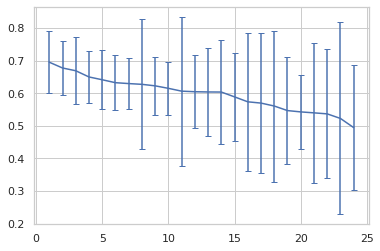

In [20]:
plt.errorbar(x=range(1, res.shape[0]+1), y=res['val.f1-score.mean'], yerr=res['val.f1-score.std'], capsize=3);

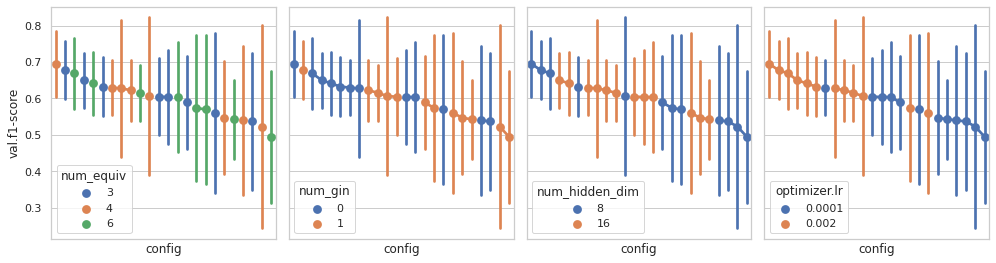

In [22]:
fig, ax = plt.subplots(1, len(hyperparams), figsize=(len(hyperparams) * 3.5, 4), sharex=True, sharey=True)

for param, a in zip(hyperparams, ax):
    sns.pointplot(x='config', y='val.f1-score', data=df, order=config_ordered_f1, ci='sd', hue=param, ax=a)

for a in ax: a.set_xticks([])
for a in ax[1:]: a.set_ylabel('')
plt.suptitle('')
plt.tight_layout()

In [26]:
df[(df.num_equiv == 4) & (df.num_gin == 0) & (df.num_hidden_dim == 8) & (df['optimizer.lr'] == 2e-3)]

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,cv.fold_id,train.accuracy,train.epoch,train.f1-score,train.loss,train.precision,...,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss,config
15,4,0,8,0.002,9,0.411765,1,0.550000,0.697113,0.407407,...,130,0.437500,1,0.608696,0.688453,0.437500,1.000000,7,0.688453,9
39,4,0,8,0.002,8,0.804636,271,0.779026,0.506337,0.759124,...,130,0.777778,271,0.714286,0.459126,0.714286,0.714286,7,0.459126,9
63,4,0,8,0.002,7,0.594771,76,0.581081,0.653951,0.518072,...,130,0.750000,76,0.666667,0.634966,0.800000,0.571429,7,0.634966,9
87,4,0,8,0.002,6,0.750000,277,0.724014,0.556693,0.677852,...,130,0.733333,277,0.750000,0.566366,0.666667,0.857143,7,0.566366,9
111,4,0,8,0.002,5,0.718954,244,0.688406,0.588769,0.650685,...,130,0.687500,244,0.615385,0.620891,0.666667,0.571429,7,0.620891,9
135,4,0,8,0.002,4,0.754967,327,0.717557,0.557790,0.712121,...,130,0.944444,327,0.923077,0.365648,1.000000,0.857143,7,0.365648,9
159,4,0,8,0.002,3,0.611111,120,0.653061,0.620709,0.525822,...,130,0.750000,120,0.750000,0.551882,0.666667,0.857143,7,0.551882,9
183,4,0,8,0.002,2,0.601307,54,0.523438,0.666592,0.531746,...,130,0.687500,54,0.666667,0.624796,0.625000,0.714286,7,0.624796,9
207,4,0,8,0.002,1,0.627517,98,0.621160,0.631474,0.551515,...,128,0.700000,98,0.625000,0.583400,0.625000,0.625000,8,0.583400,9
231,4,0,8,0.002,0,0.741722,160,0.713235,0.548790,0.673611,...,128,0.611111,160,0.631579,0.559985,0.545455,0.750000,8,0.559985,9


In [27]:
df[(df.num_equiv == 3) & (df.num_gin == 1) & (df.num_hidden_dim == 8) & (df['optimizer.lr'] == 2e-3)]

,num_equiv,num_gin,num_hidden_dim,optimizer.lr,cv.fold_id,train.accuracy,train.epoch,train.f1-score,train.loss,train.precision,...,train.support,val.accuracy,val.epoch,val.f1-score,val.loss,val.precision,val.recall,val.support,val_loss,config
19,3,1,8,0.002,9,0.486928,4,0.587927,0.692047,0.446215,...,130,0.437500,4,0.608696,0.695991,0.437500,1.000000,7,0.695991,5
43,3,1,8,0.002,8,0.837748,518,0.815094,0.469122,0.800000,...,130,0.833333,518,0.769231,0.412706,0.833333,0.714286,7,0.412706,5
67,3,1,8,0.002,7,0.542484,114,0.580838,0.661614,0.475490,...,130,0.750000,114,0.750000,0.586984,0.666667,0.857143,7,0.586984,5
91,3,1,8,0.002,6,0.698052,283,0.678201,0.592825,0.616352,...,130,0.866667,283,0.833333,0.534299,1.000000,0.714286,7,0.534299,5
115,3,1,8,0.002,5,0.428105,1,0.597701,0.705688,0.426230,...,130,0.437500,1,0.608696,0.690862,0.437500,1.000000,7,0.690862,5
139,3,1,8,0.002,4,0.609272,110,0.562963,0.671473,0.542857,...,130,0.555556,110,0.600000,0.679112,0.461538,0.857143,7,0.679112,5
163,3,1,8,0.002,3,0.633987,85,0.631579,0.637503,0.551724,...,130,0.625000,85,0.666667,0.594814,0.545455,0.857143,7,0.594814,5
187,3,1,8,0.002,2,0.653595,141,0.558333,0.637181,0.609091,...,130,0.687500,141,0.705882,0.596353,0.600000,0.857143,7,0.596353,5
211,3,1,8,0.002,1,0.651007,343,0.617647,0.624926,0.583333,...,128,0.650000,343,0.631579,0.591993,0.545455,0.750000,8,0.591993,5
235,3,1,8,0.002,0,0.622517,56,0.592857,0.657469,0.546053,...,128,0.555556,56,0.600000,0.583694,0.500000,0.750000,8,0.583694,5


# Changed early stopping behaviour

## Sweep 1

Very small grid

In [32]:
hyperparams = ['epochs', 'optimizer.lr']
metrics = ['train.f1-score', 'val.f1-score', 'train.epoch']

path = setup.get_local_data_path().joinpath('wandb_export_sweep_z0wl75wc.csv')
df = pd.read_csv(path)
df = df[hyperparams + metrics + ['cv.fold_id']]
df

,epochs,optimizer.lr,train.f1-score,val.f1-score,train.epoch,cv.fold_id
0,180,0.00050,0.669388,0.466667,112,4
1,180,0.00003,0.637427,0.400000,118,4
2,180,0.00100,0.637450,0.437500,102,4
3,60,0.00050,0.651515,0.347826,60,4
4,60,0.00003,0.601036,0.583333,60,4
5,60,0.00100,0.642857,0.451613,60,4
6,180,0.00050,0.686792,0.600000,180,3
7,180,0.00003,0.580645,0.666667,102,3
8,180,0.00100,0.731707,0.538462,180,3
9,60,0.00050,0.674157,0.538462,60,3


In [40]:
df.drop(columns='cv.fold_id').groupby(hyperparams).agg(['mean', 'std', 'min']).sort_values(('val.f1-score', 'mean'), ascending=False)

train.f1-score                     val.f1-score            \
                              mean       std       min         mean       std   
epochs optimizer.lr                                                             
60     0.00003            0.586792  0.019908  0.552189     0.581777  0.043524   
180    0.00050            0.720087  0.042550  0.669388     0.538135  0.058423   
       0.00003            0.618515  0.022193  0.580645     0.526110  0.103681   
60     0.00100            0.605956  0.043027  0.541063     0.521189  0.087855   
180    0.00100            0.667622  0.047645  0.623482     0.493564  0.077683   
60     0.00050            0.630404  0.030799  0.604255     0.424503  0.073811   

                              train.epoch                  
                          min        mean        std  min  
epochs optimizer.lr                                        
60     0.00003       0.540541        60.0   0.000000   60  
180    0.00050       0.466667       155.4  33.997059  112  
       0.00003       0.400000       138.0  36.193922  102  
60     0.00100       0.413793        60.0   0.000000   60  
180    0.00100       0.387097       148.8  42.722359  102  
60     0.00050       0.347826        60.0   0.000000   60

## Sweep 2

Bigger grid

In [56]:
hyperparams = ['epochs', 'optimizer.lr', 'num_equiv', 'num_gin']
metrics = ['train.f1-score', 'val.f1-score', 'train.epoch']

path = setup.get_local_data_path().joinpath('wandb_export_sweep_3esnf3hi.csv')
raw = pd.read_csv(path)
df = raw[hyperparams + metrics + ['cv.fold_id']]
df

,epochs,optimizer.lr,num_equiv,num_gin,train.f1-score,val.f1-score,train.epoch,cv.fold_id
0,120,0.00050,5,1,0.655870,0.516129,109,4
1,120,0.00003,5,1,0.591362,0.536585,120,4
2,120,0.00050,5,0,0.646809,0.500000,108,4
3,120,0.00003,5,0,0.615385,0.533333,120,4
4,120,0.00050,4,1,0.686347,0.444444,102,4
...,...,...,...,...,...,...,...,...
115,60,0.00003,4,0,0.578778,0.511628,60,0
116,60,0.00050,3,1,0.606742,0.363636,60,0
117,60,0.00003,3,1,0.633136,0.523810,60,0
118,60,0.00050,3,0,0.616000,0.685714,60,0


In [57]:
res = df.drop(columns='cv.fold_id').groupby(hyperparams).agg(['mean', 'std', 'min']).sort_values(('val.f1-score', 'mean'), ascending=False)
res

train.f1-score                      \
                                                mean       std       min   
epochs optimizer.lr num_equiv num_gin                                      
120    0.00003      4         1             0.601309  0.029226  0.552727   
                    3         0             0.595038  0.010761  0.579926   
60     0.00003      3         0             0.583068  0.055679  0.484536   
       0.00050      3         0             0.631134  0.042106  0.574899   
120    0.00050      3         0             0.653985  0.051340  0.609756   
       0.00003      3         1             0.593353  0.030340  0.557377   
60     0.00003      4         1             0.598659  0.005678  0.591837   
       0.00050      3         1             0.631916  0.044352  0.585153   
120    0.00003      5         1             0.604204  0.033623  0.558282   
60     0.00050      5         1             0.583255  0.052336  0.493506   
120    0.00050      5         0             0.700117  0.040346  0.646809   
60     0.00050      4         1             0.621882  0.035358  0.577947   
120    0.00003      4         0             0.609011  0.019977  0.588997   
       0.00050      4         0             0.716722  0.040313  0.655602   
                              1             0.693450  0.043954  0.651341   
60     0.00003      3         1             0.485409  0.271805  0.000000   
120    0.00050      5         1             0.662994  0.051395  0.604839   
60     0.00003      5         1             0.469660  0.262910  0.000000   
120    0.00050      3         1             0.666936  0.049072  0.629032   
60     0.00050      5         0             0.626942  0.037498  0.595238   
                    4         0             0.628209  0.034196  0.586873   
       0.00003      5         0             0.488757  0.214142  0.112000   
120    0.00003      5         0             0.600932  0.023936  0.568266   
60     0.00003      4         0             0.551277  0.095087  0.389474   

                                      val.f1-score                      \
                                              mean       std       min   
epochs optimizer.lr num_equiv num_gin                                    
120    0.00003      4         1           0.599780  0.090334  0.486486   
                    3         0           0.589922  0.055506  0.511628   
60     0.00003      3         0           0.559346  0.094271  0.400000   
       0.00050      3         0           0.552225  0.114456  0.387097   
120    0.00050      3         0           0.542698  0.098307  0.444444   
       0.00003      3         1           0.536533  0.090728  0.388889   
60     0.00003      4         1           0.536188  0.099112  0.413793   
       0.00050      3         1           0.529005  0.101088  0.363636   
120    0.00003      5         1           0.521738  0.070679  0.424242   
60     0.00050      5         1           0.518250  0.109577  0.342857   
120    0.00050      5         0           0.510602  0.139994  0.272727   
60     0.00050      4         1           0.507889  0.097782  0.400000   
120    0.00003      4         0           0.507350  0.046129  0.457143   
       0.00050      4         0           0.504278  0.082565  0.413793   
                              1           0.494445  0.115711  0.400000   
60     0.00003      3         1           0.462540  0.260949  0.000000   
120    0.00050      5         1           0.462440  0.153101  0.260870   
60     0.00003      5         1           0.448599  0.253289  0.000000   
120    0.00050      3         1           0.442400  0.114491  0.272727   
60     0.00050      5         0           0.429288  0.133316  0.210526   
                    4         0           0.428452  0.110657  0.250000   
       0.00003      5         0           0.421002  0.273576  0.000000   
120    0.00003      5         0           0.409231  0.182623  0.090909   
60     0.00003      4         0           0.407357  0.238356 

In [53]:
df_latex = res.copy().head(5)
print(df_latex.to_latex(float_format='%.3f'))

\begin{tabular}{llllrrrrrrrrr}
\toprule
    &         &   &   & \multicolumn{3}{l}{train.f1-score} & \multicolumn{3}{l}{val.f1-score} & \multicolumn{3}{l}{train.epoch} \\
    &         &   &   &           mean &   std &   min &         mean &   std &   min &        mean &   std &  min \\
epochs & optimizer.lr & num\_equiv & num\_gin &                &       &       &              &       &       &             &       &      \\
\midrule
120 & 0.00003 & 4 & 1 &          0.601 & 0.029 & 0.553 &        0.600 & 0.090 & 0.486 &     113.400 & 7.603 &  102 \\
    &         & 3 & 0 &          0.595 & 0.011 & 0.580 &        0.590 & 0.056 & 0.512 &     114.800 & 7.155 &  106 \\
60  & 0.00003 & 3 & 0 &          0.583 & 0.056 & 0.485 &        0.559 & 0.094 & 0.400 &      60.000 & 0.000 &   60 \\
    & 0.00050 & 3 & 0 &          0.631 & 0.042 & 0.575 &        0.552 & 0.114 & 0.387 &      60.000 & 0.000 &   60 \\
120 & 0.00050 & 3 & 0 &          0.654 & 0.051 & 0.610 &        0.543 & 0.098 & 0.444 & 

## Visualize learning curves

In [117]:
def get_config_dicts(df):
    names = df.index.names
    configs = [
        dict(zip(names, index_entry))
        for index_entry in df.index.values
    ]
    return configs

In [120]:
configs = get_config_dicts(res)
configs[:5]

[{'epochs': 120, 'optimizer.lr': 3e-05, 'num_equiv': 4, 'num_gin': 1},
 {'epochs': 120, 'optimizer.lr': 3e-05, 'num_equiv': 3, 'num_gin': 0},
 {'epochs': 60, 'optimizer.lr': 3e-05, 'num_equiv': 3, 'num_gin': 0},
 {'epochs': 60, 'optimizer.lr': 0.0005, 'num_equiv': 3, 'num_gin': 0},
 {'epochs': 120, 'optimizer.lr': 0.0005, 'num_equiv': 3, 'num_gin': 0}]

In [62]:
import wandb

In [63]:
api = wandb.Api()
runs = api.runs('mazeller/egnn-mi', filters={'sweep': '3esnf3hi'})
len(runs)

120

In [73]:
df_summary, df_config = wandb_export.process_runs(runs)

2022-03-20 17:54:13,428 [wandb_export] [INFO] extracting runs metadata
2022-03-20 17:54:14,464 [wandb_export] [INFO] extracting runs summary and config
2022-03-20 17:54:14,729 [wandb_export] [INFO] expanding column val
2022-03-20 17:54:14,731 [wandb_export] [INFO] expanding column train


In [124]:
def filter_config(input_df, config):
    mask = input_df[config.keys()] == config.values()
    return input_df[mask.all(axis=1)]

In [126]:
df_filtered = filter_config(df_config, configs[0])
df_filtered

,epochs,cv.seed,num_gin,physics,cv.k_fold,num_equiv,allow_stop,batch_size,cv.fold_id,early_stop,...,loss.weight,dataset.name,optimizer.lr,cv.valid_ratio,num_hidden_dim,optimizer.name,dataset.in_memory,optimizer.momentum,dataset.num_node_features,dataset.num_graph_features
id,,,,,,,,,,,,,,,,,,,,,
e53k7m37,120,0,1,0,5,4,100,8,4,100,...,0.6,CoordToCnc_KNN5,0.00003,None,8,Adam,True,0,0,3
ohke25mo,120,0,1,0,5,4,100,8,3,100,...,0.6,CoordToCnc_KNN5,0.00003,None,8,Adam,True,0,0,3
fi88mdvm,120,0,1,0,5,4,100,8,2,100,...,0.6,CoordToCnc_KNN5,0.00003,None,8,Adam,True,0,0,3
hou5wsjm,120,0,1,0,5,4,100,8,1,100,...,0.6,CoordToCnc_KNN5,0.00003,None,8,Adam,True,0,0,3
420x6hoj,120,0,1,0,5,4,100,8,0,100,...,0.6,CoordToCnc_KNN5,0.00003,None,8,Adam,True,0,0,3


In [131]:
# Sanity check
df_summary[df_summary.index.isin(df_filtered.index)]['val.f1-score'].mean()

0.5997799809673274

In [132]:
config_runs = [run for run in runs if run.id in df_filtered.index]
len(config_runs)

5

In [133]:
df_hist = wandb_export.concat_runs_history(config_runs)
df_hist

2022-03-20 18:12:08,087 [wandb_export] [INFO] extracting runs history


,id,train.support,val.support,val.epoch,train.loss,_step,train.epoch,val.f1-score,train.precision,_runtime,val_f1_score,val.precision,val.recall,train.accuracy,val.loss,train.f1-score,val.accuracy,train.recall,_timestamp,val_loss
step,,,,,,,,,,,,,,,,,,,,
0,e53k7m37,116,14,1,0.691186,0,1,0.634146,0.448052,8,0.634146,0.481481,0.928571,0.511111,0.687946,0.511111,0.558824,0.594828,1647790121,0.687946
1,e53k7m37,116,14,2,0.692604,1,2,0.634146,0.441964,8,0.634146,0.481481,0.928571,0.474074,0.688133,0.582353,0.558824,0.853448,1647790121,0.688133
2,e53k7m37,116,14,3,0.692318,2,3,0.619048,0.447826,9,0.619048,0.464286,0.928571,0.481481,0.688419,0.595376,0.529412,0.887931,1647790122,0.688419
3,e53k7m37,116,14,4,0.691956,3,4,0.619048,0.429752,10,0.619048,0.464286,0.928571,0.444444,0.688776,0.581006,0.529412,0.896552,1647790123,0.688776
4,e53k7m37,116,14,5,0.691591,4,5,0.619048,0.438525,10,0.619048,0.464286,0.928571,0.459259,0.688961,0.594444,0.529412,0.922414,1647790123,0.688961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,420x6hoj,114,15,116,0.679065,115,116,0.612245,0.446640,84,0.612245,0.441176,1.000000,0.469925,0.694557,0.615804,0.472222,0.991228,1647782757,0.694557
116,420x6hoj,114,15,117,0.681163,116,117,0.612245,0.448413,85,0.612245,0.441176,1.000000,0.473684,0.694733,0.617486,0.472222,0.991228,1647782758,0.694733
117,420x6hoj,114,15,118,0.683093,117,118,0.612245,0.452000,85,0.612245,0.441176,1.000000,0.481203,0.694606,0.620879,0.472222,0.991228,1647782758,0.694606


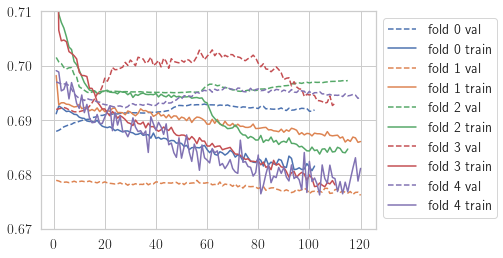

In [155]:
palette = sns.color_palette('deep', n_colors=df_hist.id.nunique())

for i, runid in enumerate(df_hist.id.unique()):
    subdf = df_hist[df_hist['id'] == runid]
    plt.plot(subdf['train.epoch'], subdf['val_loss'], '--', label=f'fold {i} val', color=palette[i])
    plt.plot(subdf['train.epoch'], subdf['train.loss'], label=f'fold {i} train', color=palette[i])
    
plt.ylim(0.67, 0.71)
plt.legend(bbox_to_anchor=(1, 1));

In [136]:
df_plot = df_hist.melt(['id', 'train.epoch'], ['train.loss', 'val.loss'], var_name='loss_type', value_name='loss')
df_plot

,id,train.epoch,loss_type,loss
0,e53k7m37,1,train.loss,0.691186
1,e53k7m37,2,train.loss,0.692604
2,e53k7m37,3,train.loss,0.692318
3,e53k7m37,4,train.loss,0.691956
4,e53k7m37,5,train.loss,0.691591
...,...,...,...,...
1129,420x6hoj,116,val.loss,0.694557
1130,420x6hoj,117,val.loss,0.694733
1131,420x6hoj,118,val.loss,0.694606
1132,420x6hoj,119,val.loss,0.694015
